# Source Witness analysis for GHZ⁶

In [1]:
import glob
import itertools
import pandas as pd
import numpy as np
import scipy as sp
from scipy import linalg,stats
from scipy.optimize import least_squares,minimize
#from numpy import random, linalg
from numpy.random import default_rng
import matplotlib.pyplot as plt
#import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm,ticker,colors,rc,font_manager
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline
import os
try:
    fm = font_manager.json_load(os.path.expanduser("~/.cache/matplotlib/fontlist-v310.json"))
except:
    fm = font_manager.json_load(os.path.expanduser("~/.cache/matplotlib/fontlist-v300.json"))
fm.findfont("serif", rebuild_if_missing=False)
rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 12})

## Some experimental parameters

In [24]:
# number of qubits
n_qbits = 6
# laser repetition rate
R = 8E7
# number of measurements
measurements = 1
# seconds per line of datafile (measurement time)
meas_time = 3
# motor angles
#mot_ang = [6,7,8]
#mot_ang = [-10,-3,2,6,9,11,13,14,15,16]
# detector lists [A1 B1 A2 B2]
addresses_sin = {'h1':1,'v1':2,'h2':5,'v2':6,'h3':3,'v3':4,'h4':7,'v4':8,'h5':11,'v5':12,'h6':16,'v6':15}
#correct for datafiles
datafile_list = False
#for key in addresses_sin:
#    addresses_sin[key] +=1
#print(addresses_sin)
#folder with measurments
fold = './witness/'

# function to create list of coincidences of n_qubits
def coinc_str_first(n,coinc_list=['h','v']):
    outs = ['h','v']
    coinc_tmp = []
    for i in coinc_list:
        for k in outs:
            coinc_tmp.append(i+k)
    if n==1:
        return outs
    elif n==2:
        return coinc_tmp
    else:
        return coinc_str_first(n-1,coinc_tmp)
    
def coinc_str(n):
    tmp_str = coinc_str_first(n)
    tmp2 = tmp_str.copy()
    for i,entry in enumerate(tmp2):
        tmp3 = ''
        for j,det in enumerate(entry):
            tmp3 += det+str(j+1)
        tmp_str[i] = tmp3
    return tmp_str

# angles for each setting in order [QWP,HWP]
#settings = [[-15,-30] for i in range(measurements)]
# actual settings
settings = [[0,0],[0,22.5],[-15,15],[-30,7.5],[-45,0],[-30,-37.5],[-15,-30]]

repeat = 1 #number of monte-carlo generations
#m_per_turn = 300 #number of measurements per turn
mot_err = 0.5 #motor error in degrees

# correct for accidentals? 'theory' or 'no'
acc_corr = 'theory'

## QI definitions

In [25]:
#convert deg to rad
def theta(x):
    return x*np.pi/180

# Lambda-Half wave plate
def HWP(x):
    return np.array([[np.cos(2*theta(x)),np.sin(2*theta(x))],[np.sin(2*theta(x)),-np.cos(2*theta(x))]])

# QWP
def QWP(x):
    return np.array([[np.cos(theta(x))**2+1j*np.sin(theta(x))**2,(1-1j)*np.sin(theta(x))*np.cos(theta(x))],
            [(1-1j)*np.sin(theta(x))*np.cos(theta(x)),np.sin(theta(x))**2+1j*np.cos(theta(x))**2]])

#pauli matrices
s0 = np.eye(2)
sx = np.array([[0, 1],[ 1, 0]])
sy = np.array([[0, -1j],[1j, 0]])
sz = np.array([[1, 0],[0, -1]])

#basis states
h = np.array([1, 0])
v = np.array([0, 1])

# Generate measurement operator for n qubits as tensor product of the same measurement sigma
def meas_multi(n,sigma):
    if n==1:
        return sigma
    else:
        return np.kron(meas_multi(n-1,sigma),sigma)

# GHZ^n state
def GHZ(nqub=6):
    ghz = np.zeros((2**nqub,1))
    ghz[0],ghz[-1] = 1/np.sqrt(2),1/np.sqrt(2)
    return ghz

# visibility
def visib(setting, data):
    if setting==0:
        vis = (data[0]+data[-1])/sum(data)
        #actual sigma_Z visibility
        #vis = (data[0]+data[-1]-sum(data[1:-1]))/sum(data)
    elif setting in range(1,len(data)):
        sett_str = coinc_str(n_qbits)
        data_plus = []
        data_minus = []
        for i,sett in enumerate(sett_str):
            if (sett.count('h')%2 == 0):
                data_plus.append(i)
            else:
                data_minus.append(i)
        num = sum([data[i] for i in data_plus]) - sum([data[i] for i in data_minus])
        vis = num/sum(data)
    else:
        print('Wrong setting number!')
    return vis

def visiX(data):
    num = sum([data[i] for i in [0,3,5,6,9,10,12,15]]) - sum([data[i] for i in [1,2,4,7,8,11,13,14]])
    vis = num/sum(data)
    return vis

#file_lenght
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

#file_len(fold+'1_datafile.dat')

### Define addresses to import, with labels.
Also define accidentals

In [26]:
def Address(add_dict,datafile_list):
    addresses = {}
    dets = []
    for i in range(int(len(add_dict)/2)):
        dets.append(dict(itertools.islice(add_dict.items(), 2*i, 2*i+2)))
    
    if len(add_dict)//2 == 6:
        # 6-photon addresses
        for comb6 in map(dict,itertools.product(*[dets[i].items() for i in range(len(dets))])):
            addresses[''.join([key for key in comb6])] = sum([2**(list(comb6.values())[i]-1) for i in range(len(comb6))])
            # 5-photon addresses
            for comb5 in map(dict,itertools.combinations(comb6.items(),5)):
                addresses[''.join([key for key in comb5])] = sum([2**(list(comb5.values())[i]-1) for i in range(len(comb5))])
                # 4-photon addresses
                for comb4 in map(dict,itertools.combinations(comb5.items(),4)):
                    addresses[''.join([key for key in comb4])] = sum([2**(list(comb4.values())[i]-1) for i in range(len(comb4))])
                    # 3-photon addresses
                    for comb3 in map(dict,itertools.combinations(comb4.items(),3)):
                        addresses[''.join([key for key in comb3])] = sum([2**(list(comb3.values())[i]-1) for i in range(len(comb3))])
                        # 2-photon addresses
                        for comb2 in map(dict,itertools.combinations(comb3.items(),2)):
                            addresses[''.join([key for key in comb2])] = sum([2**(list(comb2.values())[i]-1) for i in range(len(comb2))])
                            # 1-photon addresses
                            for comb1 in map(dict,itertools.combinations(comb2.items(),1)):
                                addresses[''.join([key for key in comb1])] = sum([2**(list(comb1.values())[i]-1) for i in range(len(comb1))])
        # list of 5-photon accidentals
        acc_list = []
        for comb in map(dict,itertools.product(*[dets[i].items() for i in range(len(dets))])):
            lst = list(map(dict,itertools.combinations(comb.items(),5)))
            tmp = []
            for el in comb:
                for item in lst:
                    if el not in item:
                        tmp.append([''.join([key for key in item]),el])
            acc_list.append(tmp) 
    
    elif len(add_dict)//2 == 4:
        # 4-photon addresses
        for comb4 in map(dict,itertools.product(*[dets[i].items() for i in range(len(dets))])):
            addresses[''.join([key for key in comb4])] = sum([2**(list(comb4.values())[i]-1) for i in range(len(comb4))])
            # 3-photon addresses
            for comb3 in map(dict,itertools.combinations(comb4.items(),3)):
                addresses[''.join([key for key in comb3])] = sum([2**(list(comb3.values())[i]-1) for i in range(len(comb3))])
                # 2-photon addresses
                for comb2 in map(dict,itertools.combinations(comb3.items(),2)):
                    addresses[''.join([key for key in comb2])] = sum([2**(list(comb2.values())[i]-1) for i in range(len(comb2))])
                    # 1-photon addresses
                    for comb1 in map(dict,itertools.combinations(comb2.items(),1)):
                        addresses[''.join([key for key in comb1])] = sum([2**(list(comb1.values())[i]-1) for i in range(len(comb1))])
        # list of 3-photon accidentals
        acc_list = []
        for comb in map(dict,itertools.product(*[dets[i].items() for i in range(len(dets))])):
            lst = list(map(dict,itertools.combinations(comb.items(),3)))
            tmp = []
            for el in comb:
                for item in lst:
                    if el not in item:
                        tmp.append([''.join([key for key in item]),el])
            acc_list.append(tmp) 
    
    #sort dictionary
    addresses = {k: v for k, v in sorted(addresses.items(), key=lambda item: item[1])}
    # fill lists of columns to import and their labels
    # name colunms
    cols_to_imp = []
    cols_labels = []

    for el in addresses:
        cols_labels.append(el)
        cols_to_imp.append(addresses[el])

    # correct addresses if datafile comes from list
    if datafile_list:
        for key in addresses:
            addresses[key] +=1
        cols_to_imp_tmp = cols_to_imp.copy()
        for i,el in enumerate(cols_to_imp_tmp):
            cols_to_imp[i] +=1
    
    return [addresses,cols_to_imp,cols_labels,acc_list]

#Address(addresses_sin, datafile_list)[3]

## Reduce and clean files

In [27]:
# Reduce datafiles
# what's the highest address needed?
def reduce_files(addresses_sin, datafile_lst=datafile_list, folder=fold):
    max_add = 1
    for det in addresses_sin:
        max_add += 2**(addresses_sin[det]-1)

    print(max_add)
    # find all data files
    all_dat_files = glob.glob(folder+'*.dat')
    dat_files = []
    for fil in all_dat_files:
        if 'red' not in fil:
            dat_files.append(fil)
    print(dat_files)

    # clean files
    # list of measurements?
    if datafile_lst:
        for file_num,fil in enumerate(dat_files):
            with open(fil) as in_f:
                # list to contain cleaned data
                cl_data = ''
                for line in in_f:
                    arry = [x for x in line.split()]
                    if arry[1]=='0':
                        for num in arry[:max_add]:
                            cl_data += num
                            cl_data += ' '
            #            cl_data += arry[max_add]
                        cl_data += '\n'
                with open(str(fil)[:-4]+'_red.dat', 'w') as o_f:
                    o_f.write(cl_data)
        
    elif not datafile_lst:
        for file_num,fil in enumerate(dat_files):
            with open(fil) as in_f:
                # list to contain cleaned data
                cl_data = ''
                for line in in_f:
                    arry = [x for x in line.split()]
                    if arry[0]=='0':
                        for num in arry[:max_add]:
                            cl_data += num
                            cl_data += ' '
            #            cl_data += arry[max_add]
                        cl_data += '\n'
                with open(str(fil)[:-4]+'_red.dat', 'w') as o_f:
                    o_f.write(cl_data)
                    
    else:
        print("Are all datafiles the same (list or not list)?")

reduce_files(addresses_sin)

52480
['./witness/1_22_5-0.dat']


## Import data

In [28]:
def file_list(setting, folder=fold):
    # find all data files

    dat_files = glob.glob(folder+'*_red.dat')
    dat_files = sorted(dat_files, key=lambda item: int(item.split('_')[0][len(folder):])) #sort datafiles

    # find out min lenght
    
    m_per_turn = file_len(dat_files[setting])

    return dat_files[setting],m_per_turn

def data_import(setting, datafile_lst=datafile_list, folder=fold):
# find all data files

    dat_file, m_per_turn = file_list(setting,folder)
    
    #m_per_turn = 4000 # override m_per_turn
    skip_rows = 0 # skip initial rows
    m_per_turn = m_per_turn-skip_rows
    counts_sing_turn = [] #holds the real data
    
    adds = Address(addresses_sin,datafile_lst)
#   df = pd.read_csv(dat_file, sep=' ', header=None, names=Address(addresses_sin)[2], usecols=Address(addresses_sin)[1], nrows=min(meas_len), engine='python')
    df = pd.read_csv(dat_file, sep=' ', header=None, names=adds[2], usecols=adds[1], skiprows=skip_rows, nrows=m_per_turn, dtype={'user_id': int})
    setting_dict = {}
    # loop on addresses
    for add in adds[0]:
        setting_dict[add] = df[add].sum()
    counts_sing_turn.append(setting_dict)

    print(setting,dat_file)
    
    return [counts_sing_turn,m_per_turn]

# generate monte-carlo data, 'repeat' amount of sets
def MC_data(real_data, reps):
    
    counts = [real_data.copy()] #will hold total counts for each address, for one setting, for each repetition
    
    if reps<2:
        return counts
    
    for turn in range(reps-1):
        new_data_round = [] #will hold new MC-generated data, for one settings
#        counter = 0

        new_data_dict = {} #will hold new MC-generated data, for one settings

        for el in real_data[0]:
            new_data_dict[el] = np.random.default_rng().normal(real_data[0][el],np.sqrt(real_data[0][el]))
        new_data_round.append(new_data_dict)
        counts.append(new_data_round)

    return counts

#print(len(MC_data(data_import(),reps=3)))

def exp_freq(setting, reps, meas_tm=meas_time, datafile_lst=datafile_list, folder=fold):
# now create vectors for experimental frequencies
    f_v = [] #n-photon counts

    data = data_import(setting, datafile_lst, folder)
    counts = MC_data(data[0],reps)
    print('Lines in datafile: {}'.format(data[1]))
    coincs = coinc_str(n_qbits)
    
    acc_all = Address(addresses_sin, datafile_lst)[3]
    
    for i,turn in enumerate(counts):
        f_v_sing_turn = []
        for m_d in counts[i]:
            if acc_corr=='theory':
                acc = []
                for row in acc_all:
                    tot = 0
                    for pair in row:
                        tot += m_d[pair[0]]*m_d[pair[1]]
                    acc.append(tot/(n_qbits*R*data[1]*meas_tm))
                norm = 0
                for i,comb in enumerate(coincs):
                    norm += max(m_d[comb]-acc[i],0)

                for i,comb in enumerate(coincs):
                    f_v_sing_turn.append(max((m_d[comb]-acc[i])/norm,0))
            elif acc_corr=='no':
                norm = sum(m_d[ff] for ff in coincs)
                #print(norm)
                for comb in coincs:
                    f_v_sing_turn.append(m_d[comb]/norm)
            else: print('Error with understanding if we want to correct for accs or not')
        f_v.append(f_v_sing_turn)
    return f_v


#data_real = exp_freq(0,2,datafile_list)

## Print rates

In [29]:
%%time
#function to extract total counts and rate per second for a list of coincidences (e.g. 'h1v2v3h4h5h6')
def tot_rate(keys, setting, meas_tm=meas_time, datafile_lst=datafile_list, folder=fold, nqbits=n_qbits):
    counts,m_per_turn = data_import(setting, datafile_lst,folder)
    
    counts_dict = counts[0]
    coincs = coinc_str(nqbits)
    acc_all = Address(addresses_sin, datafile_lst)[3]
    
    #total and total corrected
    tot = 0
    tot_co = 0
    acc = []
    for row in acc_all:
        acc_tot = 0
        for pair in row:
            acc_tot += counts_dict[pair[0]]*counts_dict[pair[1]]
        acc.append(acc_tot/(n_qbits*R*m_per_turn*meas_tm))  
    for i,key in enumerate(coincs):
        tot += counts_dict[key]
        tot_co += (max((counts_dict[key]-acc[i]),0))
            
    print('Total 6-photon events: {}. Average rate: {:.6f} Hz'.format(tot,tot/m_per_turn/meas_tm))
    print('Total 6-photon events (corrected): {:.0f}. Average rate (corrected): {:.6f} Hz'.format(tot_co,tot_co/m_per_turn/meas_tm))
    
    #find **ALL** coincs for each pair
    p1_coincT,p2_coincT,p3_coincT = 0,0,0
    for key in counts_dict:
        if (('h1' in key and 'h2' in key) or ('h1' in key and 'v2' in key) or
            ('v1' in key and 'h2' in key) or ('v1' in key and 'v2' in key) or
            ('h1' in key and 'h3' in key) or ('h1' in key and 'v3' in key) or
            ('v1' in key and 'h3' in key) or ('v1' in key and 'v3' in key) or
            ('h1' in key and 'h5' in key) or ('h1' in key and 'v5' in key) or
            ('v1' in key and 'h5' in key) or ('v1' in key and 'v5' in key)):
            p1_coincT += counts_dict[key]
        if (('h3' in key and 'h4' in key) or ('h3' in key and 'v4' in key) or
            ('v3' in key and 'h4' in key) or ('v3' in key and 'v4' in key) or
            ('h4' in key and 'h5' in key) or ('h4' in key and 'v5' in key) or
            ('v4' in key and 'h5' in key) or ('v4' in key and 'v5' in key) or
            ('h2' in key and 'h4' in key) or ('h2' in key and 'v4' in key) or
            ('v2' in key and 'h4' in key) or ('v2' in key and 'v4' in key)):
            p2_coincT += counts_dict[key]
        if (('h5' in key and 'h6' in key) or ('h5' in key and 'v6' in key) or
            ('v5' in key and 'h6' in key) or ('v5' in key and 'v6' in key) or
            ('h2' in key and 'h6' in key) or ('h2' in key and 'v6' in key) or
            ('v2' in key and 'h6' in key) or ('v2' in key and 'v6' in key)):
            p3_coincT += counts_dict[key]

    #convert totals to rates
    p1_coinc = p1_coincT/(m_per_turn*meas_tm)
    p2_coinc = p2_coincT/(m_per_turn*meas_tm)
    p3_coinc = p3_coincT/(m_per_turn*meas_tm)
                                                          
    print('Avg coincs: {:.0f} Hz. P1: {:.0f} Hz, P2: {:.0f} Hz, P3: {:.0f} Hz'.format((p1_coinc+p2_coinc+p3_coinc)/(nqbits/2),p1_coinc,p2_coinc,p3_coinc))
    
    for key in keys:
        print(key)
        print('Total: ', counts_dict[key], '; Rate: ', counts_dict[key]/m_per_turn/meas_time)

    return tot,tot_co,m_per_turn*meas_time,p1_coinc,p2_coinc,p3_coinc

#tot_rate([],0)

rates = [tot_rate([],i) for i in range(measurements)]

print('Overall:')
print('6-photon events: {}. Average rate: {:.6f} Hz'.format(sum([rates[i][0] for i in range(len(rates))]),
                                                            sum([rates[i][0] for i in range(len(rates))])/
                                                            (sum([rates[i][2] for i in range(len(rates))]))))
print('Avg coincs: P1: {:.0f} Hz, P2: {:.0f} Hz, P3: {:.0f} Hz'.format(sum([rates[i][3] for i in range(len(rates))])/len(rates),
                                                                      sum([rates[i][4] for i in range(len(rates))])/len(rates),
                                                                      sum([rates[i][5] for i in range(len(rates))])/len(rates)))

0 ./witness/1_22_5-0_red.dat
Total 6-photon events: 716. Average rate: 0.051381 Hz
Total 6-photon events (corrected): 651. Average rate (corrected): 0.046700 Hz
Avg coincs: 106389 Hz. P1: 99898 Hz, P2: 114014 Hz, P3: 105255 Hz
Overall:
6-photon events: 716. Average rate: 0.051381 Hz
Avg coincs: P1: 99898 Hz, P2: 114014 Hz, P3: 105255 Hz
CPU times: user 5.53 s, sys: 163 ms, total: 5.69 s
Wall time: 5.69 s


### Print average coincidences and n-photon rate for plotting in 'dip_vis_vs_power.ipynb'

In [30]:
print([sum(rates[i][3:])/3/1000 for i in range(len(rates))])
print([rates[i][1]/rates[i][2] for i in range(len(rates))])

[106.38905819878005]
[0.04670032299459625]


## Functions for statistical and systematic error analysis

In [6]:
## Statistical error analysis
def visi_stat(setting, reps, datafile_lst=datafile_list, folder=fold):
    visi = [] # contains visibilities for all Poisson generated data-sets

    if setting in range(len(settings)):
        f_v = exp_freq(setting, reps, meas_time, datafile_lst, folder) # contains all data (first: real data; next: MC generated)
        for i in range(reps):
            visi.append(visib(setting,f_v[i]))
            
    else:
        print('Wrong setting number!')
        
    return visi

## Systematic error analysis
def visi_syst(setting, reps, mot_err):
    visi = [] # contains visibilities for all Poisson generated data-sets

    if setting in range(len(settings)):
        for i in range(reps):
            qwp = np.random.normal(settings[setting][0],mot_err)
            hwp = np.random.normal(settings[setting][1],mot_err)
            state = meas_multi(n_qbits,QWP(qwp)@HWP(hwp))@GHZ(n_qbits)
            #state = meas_multi(n_qbits,QWP(qwp)@HWP(hwp))@state1
            visi.append(visib(setting,np.real((state*state.conj()).T[0])))
            
    else:
        print('Wrong setting number!')
        
    return visi


## Results for the different measurement settings

In [7]:
visi = [] # will contain median visibility of all settings
visi_MC = [] # will contain median visibility of all settings
visi_err_stat = [] # will contain statistical errors, negative first row, positive second row
visi_err_syst = [] # will contain systematic errors, negative first row, positive second row

st_err_neg_tmp = []
st_err_pos_tmp = []
sy_err_neg_tmp = []
sy_err_pos_tmp = []
# repeat for each setting
for i in range(len(settings)):
    vis_tmp = visi_stat(i,repeat,datafile_list,fold)
    visi.append(vis_tmp[0])
    visi_MC.append(np.median(vis_tmp))
    #statistical error
    st_err_neg_tmp.append(np.median(vis_tmp)-np.percentile(vis_tmp,50-34.1))
    st_err_pos_tmp.append(np.percentile(vis_tmp,50+34.1)-np.median(vis_tmp))
    #systematic error
    vis_sys_tmp = visi_syst(i,repeat,mot_err)
    sy_err_neg_tmp.append(np.median(vis_sys_tmp)-np.percentile(vis_sys_tmp,50-34.1))
    sy_err_pos_tmp.append(np.percentile(vis_sys_tmp,50+34.1)-np.median(vis_sys_tmp))

visi_err_stat.append(st_err_neg_tmp)
visi_err_stat.append(st_err_pos_tmp)
visi_err_syst.append(sy_err_neg_tmp)
visi_err_syst.append(sy_err_pos_tmp)
    
print('Visibilities:')
print(visi)
print('Montecarlo sampling:')
print('Visibilities (MC):')
print(visi_MC)
print('Statistical errors:')
print('-',visi_err_stat[0])
print('+',visi_err_stat[1])

print('Systematic errors:')
print('-',visi_err_syst[0])
print('+',visi_err_syst[1])

0 ./witness/Final/1_0-0_red.dat
Lines in datafile: 1371
1 ./witness/Final/2_22_5-0_red.dat
Lines in datafile: 480
2 ./witness/Final/3_15--15_red.dat
Lines in datafile: 450
3 ./witness/Final/4_7_5--30_red.dat
Lines in datafile: 700
4 ./witness/Final/5_0--45_red.dat
Lines in datafile: 649
5 ./witness/Final/6_-37_5--30_red.dat
Lines in datafile: 717
6 ./witness/Final/7_-30--15_red.dat
Lines in datafile: 400
Visibilities:
[0.7251630209418795, 0.3832736122225271, -0.37219249779663965, 0.4387153396818492, -0.40326177829587095, 0.5349513074753862, -0.44950638914337565]
Montecarlo sampling:
Visibilities (MC):
[0.7223954890969648, 0.3818158746508745, -0.3709202371955174, 0.43478034757391354, -0.400307472612906, 0.5281260277039811, -0.4402201979290923]
Statistical errors:
- [0.015172197083440198, 0.027631651977085614, 0.03348037669758924, 0.04091600111757682, 0.03917720703142524, 0.0402711089500809, 0.05528479803284958]
+ [0.017363511637611517, 0.03030902629822746, 0.028120543452373525, 0.036002

## Plot $\gamma^6$ GHZ⁶ witness operators

/usr/lib/python3/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


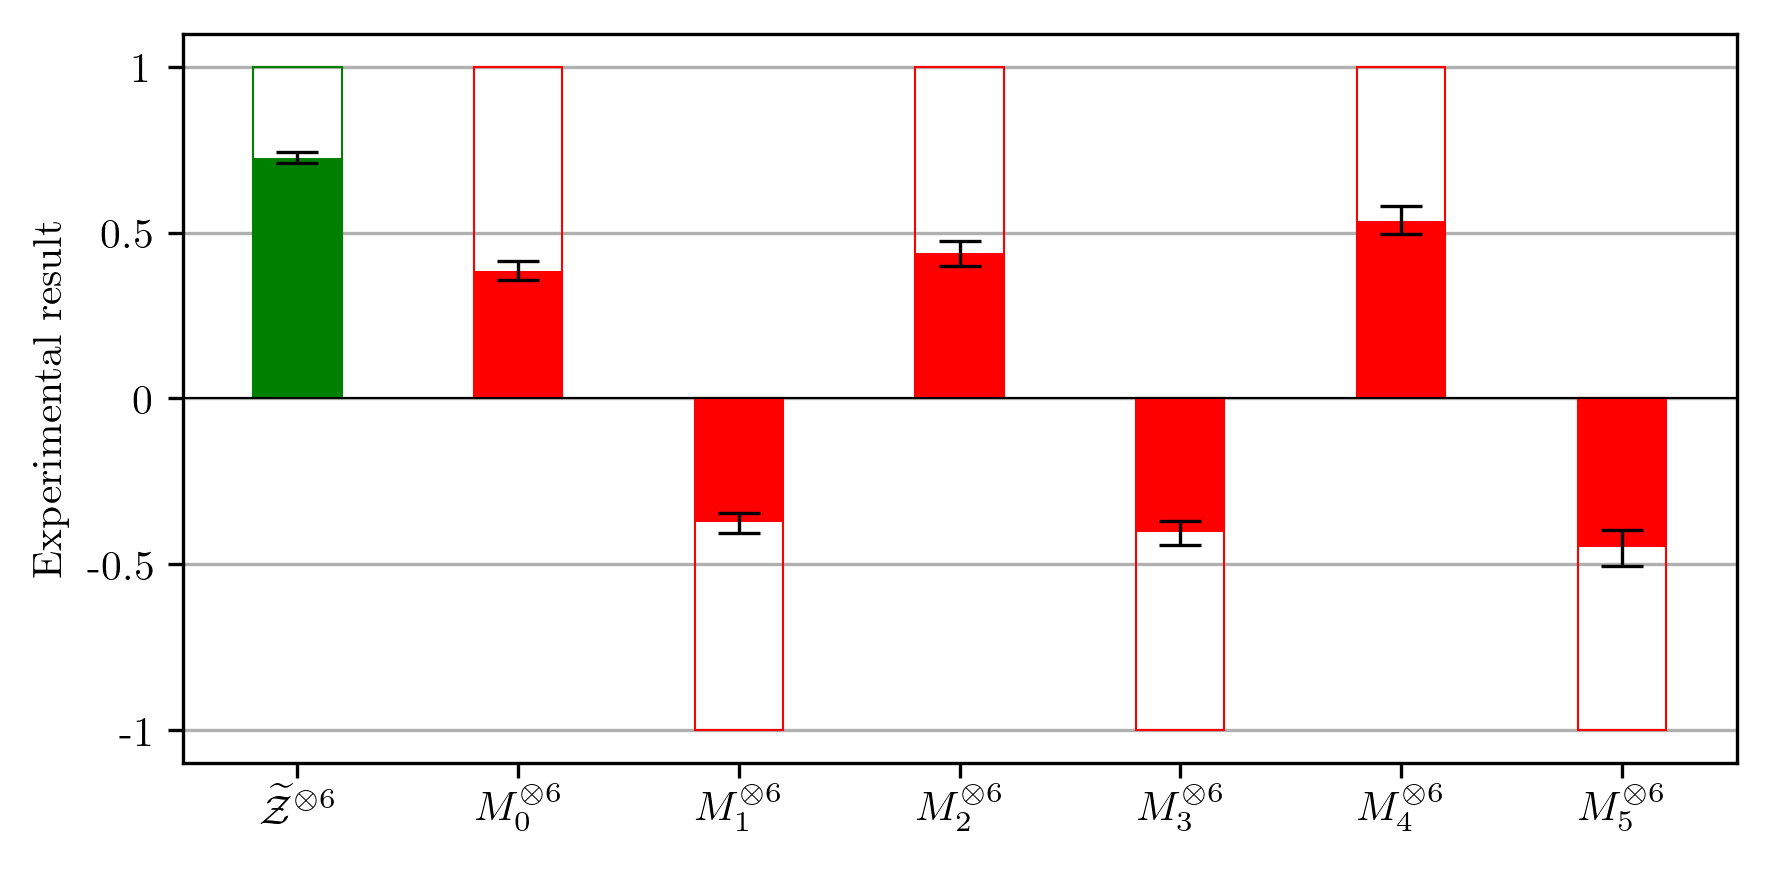

In [8]:
theory = [1,1,-1,1,-1,1,-1]

cols = ['g', 'r', 'r', 'r', 'r', 'r', 'r']

fig = plt.figure(figsize=(6,3), dpi=300)
ax = fig.add_subplot(1, 1, 1)
#txt = fig.add_subplot(2, 1, 2)

x = np.arange(len(visi))    # the x locations for the groups
width = 0.4    # the width of the bars

ax.grid(axis='y')
ax.set_axisbelow(True)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

ax.axhline(c='k', linewidth=.5)
t1 = ax.bar(x, theory, width, color=[(0, 0, 0, 0)]*len(x), edgecolor=cols, linewidth=.5)
#p1 = ax.bar(x, visi, width, color=cols)
#with error caps
p1 = ax.bar(x, visi, width, color=cols, yerr=visi_err_stat, capsize=5, error_kw={'elinewidth':.8,'capthick':.8})

ax.set_ylim(-1.1,1.1)
ax.set_ylabel('Experimental result')
plt.xticks(x, ('$\widetilde{\mathcal{Z}}^{\otimes 6}$', '$M_0^{\otimes 6}$', '$M_1^{\otimes 6}$', 
               '$M_2^{\otimes 6}$', '$M_3^{\otimes 6}$', 
               '$M_4^{\otimes 6}$', '$M_5^{\otimes 6}$'))

#ax.text(0.165,0.3,'Fidelity [\%]:\n$76.1\,^{+1.8}_{-1.7}\,^{+0.2}_{-0.2}$',fontsize=16,horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,
#       bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))

plt.draw()

fig.tight_layout()
fig.savefig("GHZ6-HR-witness-operators.pdf", format='pdf', bbox_inches='tight')
fig.savefig("GHZ6-HR-witness-operators.png", format='png', bbox_inches='tight')
#fig.savefig("GHZ6-witness-operators_withResults.pdf", format='pdf', bbox_inches='tight')
#fig.savefig("GHZ6-witness-operators_withResults.png", format='png', bbox_inches='tight')

## $\gamma^6$ GHZ⁶ - Fidelity results

In [9]:
#visi[0] = 0.912
fidelity = visi[0]/2 + sum([(-1)**(i-1)*visi[i] for i in range(1,len(visi))])/(2*n_qbits)
#statistical
fid_stat_err_neg = np.sqrt(visi_err_stat[0][0]**2/4 + 
                       sum([visi_err_stat[0][i]**2 for i in range(1,len(visi))])/(2*n_qbits)**2)
fid_stat_err_pos = np.sqrt(visi_err_stat[1][0]**2/4 + 
                       sum([visi_err_stat[1][i]**2 for i in range(1,len(visi))])/(2*n_qbits)**2)
#systematic
fid_syst_err_neg = np.sqrt(visi_err_syst[0][0]**2/4 + 
                       sum([visi_err_syst[0][i]**2 for i in range(1,len(visi))])/(2*n_qbits)**2)
fid_syst_err_pos = np.sqrt(visi_err_syst[1][0]**2/4 + 
                       sum([visi_err_syst[1][i]**2 for i in range(1,len(visi))])/(2*n_qbits)**2)

print('Fidelity: ',fidelity)
print('Statistical errors:')
print('-',fid_stat_err_neg)
print('+',fid_stat_err_pos)

print('Systematic errors:')
print('-',fid_syst_err_neg)
print('+',fid_syst_err_pos)

Fidelity:  0.5777399208555771
Statistical errors:
- 0.011198532871054675
+ 0.011761810151522
Systematic errors:
- 0.0022763067707268396
+ 0.0017190563300058543


## Results

In [ ]:
visi = [0.844143672771198, 0.6267704846024863, -0.7039688500070054, 0.6515153352369635, -0.6256907094684134, 0.6897456005311505, -0.771853528402862]
visi_MC = [0.8356546712142874, 0.609265824413696, -0.6891078685648285, 0.6419320868247234, -0.6071458941431009, 0.6759281999076568, -0.7568231962362664]
visi_err_stat = [[0.028625451099260846, 0.0584897264009423, 0.04889455005127352, 0.0463425863899255, 0.05912412432943559, 0.04438520656489575, 0.04475086244614601],
                 [0.02625107583450037, 0.05594704808781892, 0.04865256429528275, 0.042531119455556765, 0.06152242151582066, 0.04510089250463989, 0.04305476339248504]]
visi_err_syst = [[0.0036314406066587646, 0.011562975962915334, 0.003809969312780437, 0.008136998372900273, 0.0021767289528330513, 0.009008107359659068, 0.004199313629753343],
                 [0.0012430485322394436, 0.004741774057898551, 0.01094826336248833, 0.0026006392768596065, 0.009147908100315072, 0.0026442200003564675, 0.009738878302152476]]